# Imports and installations

In [2]:
!pip install -q kaggle

In [3]:
!pip install colorama

In [4]:
!mkdir -p ~/.kaggle
!echo '{"username":"nadavtoledo","key":"5d9c3ed26442f4ef927e92a2c0b6e8aa"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

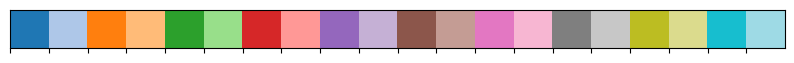

In [5]:
import gc
import io
import os
import re
import ast
import sys
import cv2
import PIL
import copy
import gzip
import h5py
import json
import math
import time
import urllib
import random
import shutil
import string
import pickle
import sklearn
import plotly
import hashlib
import imageio
import IPython
import zipfile
import requests
import textwrap
import warnings
import matplotlib
import subprocess
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import lightgbm as lgb
import plotly.express as px
from zipfile import ZipFile
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
from dataclasses import dataclass
from matplotlib import animation, rc
from colorama import Fore, Style, init
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from IPython.core.display import HTML, Markdown
from PIL import Image, ImageEnhance, ImageColor
from sklearn.preprocessing import OrdinalEncoder
from typing import Iterable, Any, Callable, Generator
from sklearn.model_selection import KFold, GroupKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc, roc_auc_score

def hex_to_rgb(hex_color: str) -> tuple:
    """Convert hex color to RGB tuple.

    Args:
        hex_color (str): The hex color string, starting with '#'.

    Returns:
        tuple: A tuple of RGB values.
    """
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def clr_print(text: str, color: str = "#42BFBA", bold: bool = True) -> None:
    """Print the given text with the specified color and bold formatting.

    Args:
        text (str): The text to format.
        color (str): The hex color code to apply. Defaults to "#752F55".
        bold (bool): Whether to apply bold formatting. Defaults to True.
    """
    _text = text.replace('\n', '<br>')
    rgb = hex_to_rgb(color)
    color_style = f"color: rgb({rgb[0]}, {rgb[1]}, {rgb[2]});"
    bold_style = "font-weight: bold;" if bold else ""
    style = f"{color_style} {bold_style}"
    display(HTML(f"<span style='{style}'>{_text}</span>"))

def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)

seed_it_all()

# Create a Seaborn color palette
nb_palette = sns.color_palette(palette='tab20')

# Create colors for class labels
LABELS = ["Benign", "Malignant"]
COLORS = ['#66c2a5', '#fc8d62']
CLR_MAP_I2C = {i:c for i,c in enumerate(COLORS)}
CLR_MAP_S2C = {l:c for l,c in zip(LABELS, COLORS)}
LBL_MAP_I2S = {i:l for i,l in enumerate(LABELS)}
LBL_MAP_S2I = {v:k for k,v in LBL_MAP_I2S.items()}

# Is this notebook being run on the backend for scoring re-submission
IS_DEBUG = False if os.getenv('KAGGLE_IS_COMPETITION_RERUN') else True

# Plot the palette
clr_print("\n... NOTEBOOK COLOUR PALETTE ...")
sns.palplot(nb_palette, size=0.5)
plt.show()


# Data loading

In [6]:
# Download the dataset using Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
api.competition_download_files('isic-2024-challenge', path='isic-2024-challenge')

# Unzip the downloaded dataset
with zipfile.ZipFile('isic-2024-challenge/isic-2024-challenge.zip', 'r') as zip_ref:
    zip_ref.extractall('isic-2024-challenge')

# Load train-metadata.csv into a DataFrame
df = pd.read_csv('isic-2024-challenge/train-metadata.csv')


/tmp/ipython-input-6-138444424.py:13: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('isic-2024-challenge/train-metadata.csv')


# EDA

of each column and what it symbolizes says

In [7]:
METADATA_COL2NAME = {
    "isic_id": "Unique Case Identifier",
    "target": "Binary Lession Classification",
    "patient_id": "Unique Patient Identifier",
    "age_approx": "Approximate Age",
    "sex": "Sex",
    "anatom_site_general": "General Anatomical Location",
    "clin_size_long_diam_mm": "Clinical Size (Longest Diameter in mm)",
    "image_type": "Image Type",
    "tbp_tile_type": "TBP Tile Type",
    "tbp_lv_A": "Color Channel A Inside Lesion",
    "tbp_lv_Aext": "Color Channel A Outside Lesion",
    "tbp_lv_B": "Color Channel B Inside Lesion",
    "tbp_lv_Bext": "Color Channel B Outside Lesion",
    "tbp_lv_C": "Chroma Inside Lesion",
    "tbp_lv_Cext": "Chroma Outside Lesion",
    "tbp_lv_H": "Hue Inside Lesion",
    "tbp_lv_Hext": "Hue Outside Lesion",
    "tbp_lv_L": "Luminance Inside Lesion",
    "tbp_lv_Lext": "Luminance Outside Lesion",
    "tbp_lv_areaMM2": "Lesion Area (mm²)",
    "tbp_lv_area_perim_ratio": "Area-to-Perimeter Ratio",
    "tbp_lv_color_std_mean": "Mean Color Irregularity",
    "tbp_lv_deltaA": "Delta A (Inside vs. Outside)",
    "tbp_lv_deltaB": "Delta B (Inside vs. Outside)",
    "tbp_lv_deltaL": "Delta L (Inside vs. Outside)",
    "tbp_lv_deltaLB": "Delta LB (Contrast)",
    "tbp_lv_deltaLBnorm": "Normalized Delta LB (Contrast)",
    "tbp_lv_eccentricity": "Eccentricity",
    "tbp_lv_location": "Detailed Anatomical Location",
    "tbp_lv_location_simple": "Simplified Anatomical Location",
    "tbp_lv_minorAxisMM": "Smallest Diameter (mm)",
    "tbp_lv_nevi_confidence": "Nevus Confidence Score",
    "tbp_lv_norm_border": "Normalized Border Irregularity",
    "tbp_lv_norm_color": "Normalized Color Variation",
    "tbp_lv_perimeterMM": "Lesion Perimeter (mm)",
    "tbp_lv_radial_color_std_max": "Radial Color Standard Deviation",
    "tbp_lv_stdL": "Standard Deviation of Luminance (Inside)",
    "tbp_lv_stdLExt": "Standard Deviation of Luminance (Outside)",
    "tbp_lv_symm_2axis": "Symmetry (Second Axis)",
    "tbp_lv_symm_2axis_angle": "Symmetry Angle (Second Axis)",
    "tbp_lv_x": "X-Coordinate",
    "tbp_lv_y": "Y-Coordinate",
    "tbp_lv_z": "Z-Coordinate",
    "attribution": "Image Source",
    "copyright_license": "Copyright License",
    "lesion_id": "Unique Lesion Identifier",
    "iddx_full": "Full Diagnosis",
    "iddx_1": "First Level Diagnosis",
    "iddx_2": "Second Level Diagnosis",
    "iddx_3": "Third Level Diagnosis",
    "iddx_4": "Fourth Level Diagnosis",
    "iddx_5": "Fifth Level Diagnosis",
    "mel_mitotic_index": "Mitotic Index (Melanoma)",
    "mel_thick_mm": "Thickness of Melanoma (mm)",
    "tbp_lv_dnn_lesion_confidence": "Lesion Confidence Score"
}

##General data check

###null

In [8]:
print(df.isnull().sum())

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

###How many different values ​​are there in each column

In [9]:
df.nunique()

,0
isic_id,401059
target,2
patient_id,1042
age_approx,16
sex,2
anatom_site_general,5
clin_size_long_diam_mm,1758
image_type,1
tbp_tile_type,2
tbp_lv_A,386052


###Distribution

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,401059.0,0.000980,0.031288,0.000000e+00,0.000000,0.000000,0.000000,1.000000
age_approx,398261.0,58.012986,13.596165,5.000000e+00,50.000000,60.000000,70.000000,85.000000
clin_size_long_diam_mm,401059.0,3.930827,1.743068,1.000000e+00,2.840000,3.370000,4.380000,28.400000
tbp_lv_A,401059.0,19.974007,3.999489,-2.487115e+00,17.330821,19.801910,22.304628,48.189610
tbp_lv_Aext,401059.0,14.919247,3.529384,-9.080269e+00,12.469740,14.713930,17.137175,37.021680
tbp_lv_B,401059.0,28.281706,5.278676,-7.309895e-01,24.704372,28.171570,31.637429,54.306900
tbp_lv_Bext,401059.0,26.913015,4.482994,9.237066e+00,23.848125,26.701704,29.679913,48.372700
tbp_lv_C,401059.0,34.786341,5.708469,3.054228e+00,31.003148,34.822580,38.430298,58.765170
tbp_lv_Cext,401059.0,30.921279,4.829345,1.184652e+01,27.658285,30.804893,33.963868,54.305290
tbp_lv_H,401059.0,54.653689,5.520849,-1.574164e+00,51.566273,55.035632,58.298184,105.875784


###Correlation between columns

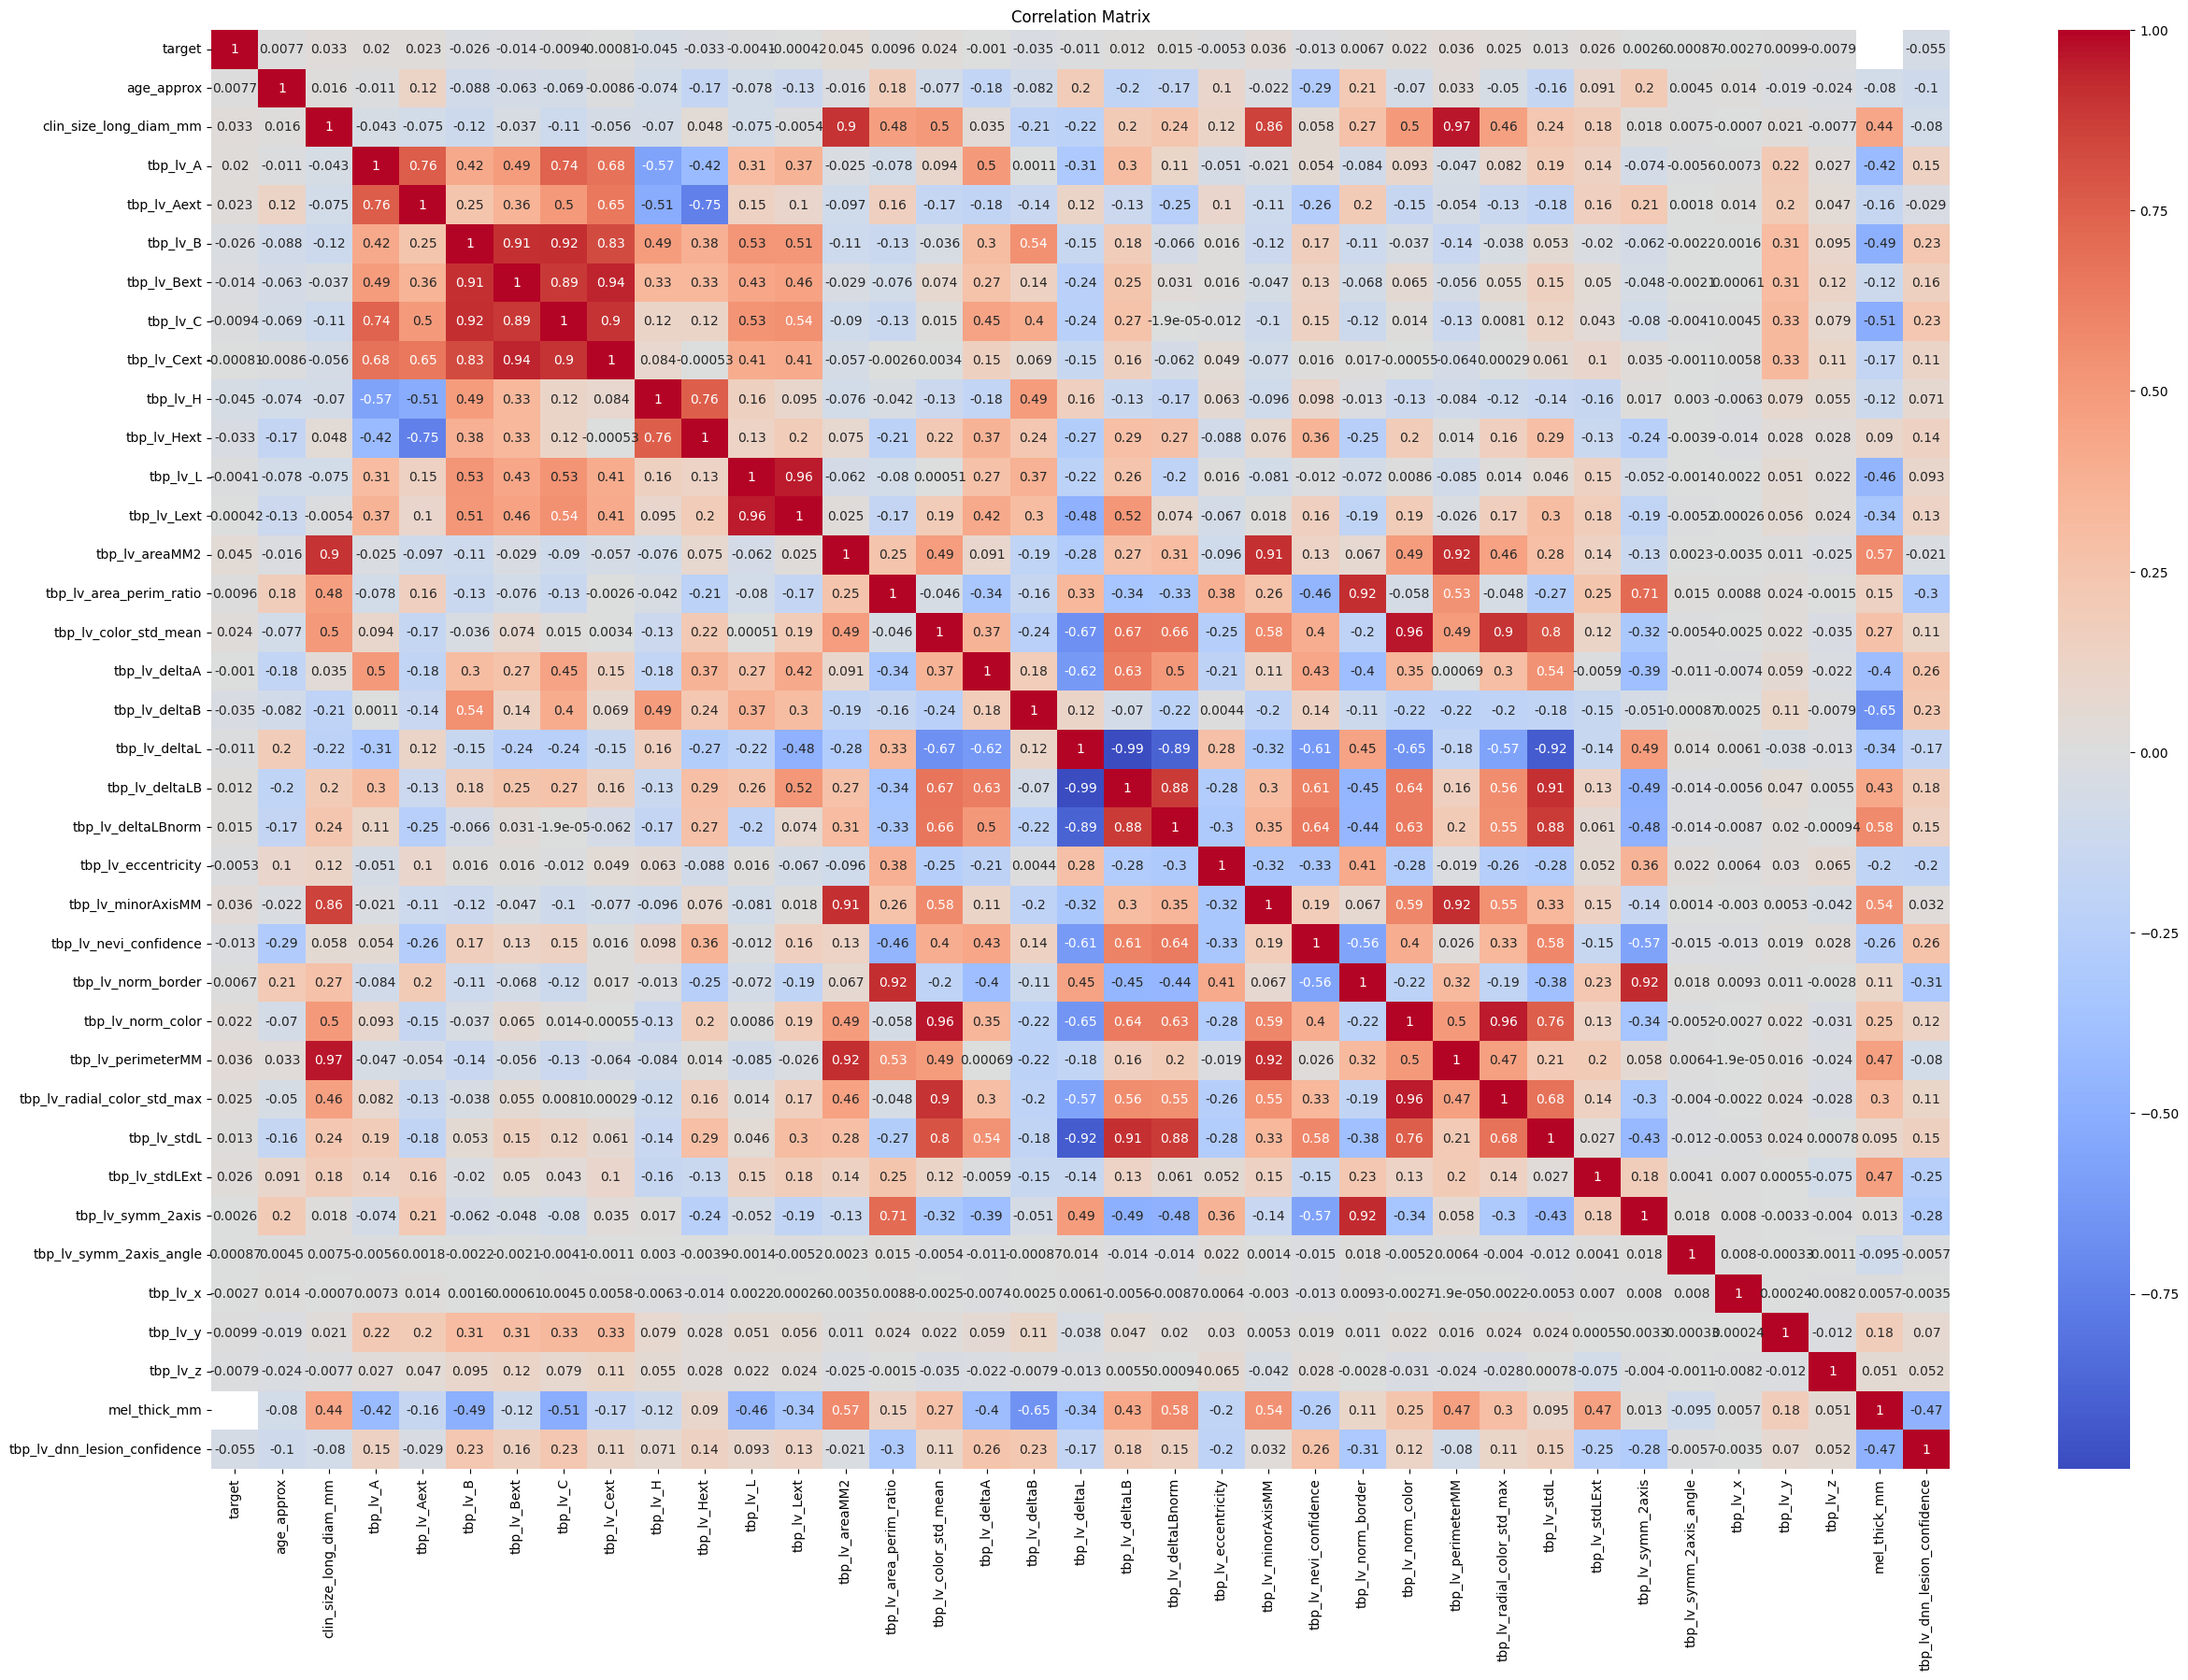

In [11]:
# Filter only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Plot the correlation matrix
corr = numeric_df.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

##General investigation of key columns

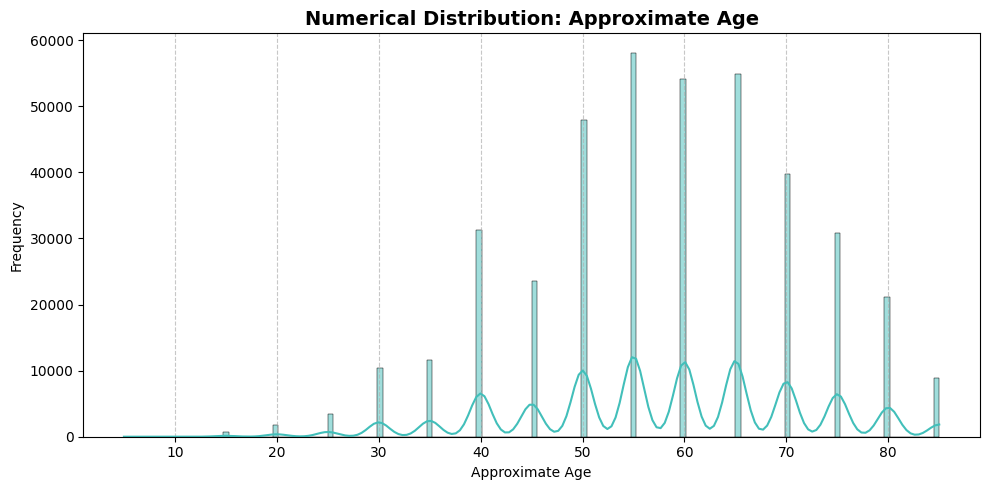

/tmp/ipython-input-12-1815431233.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


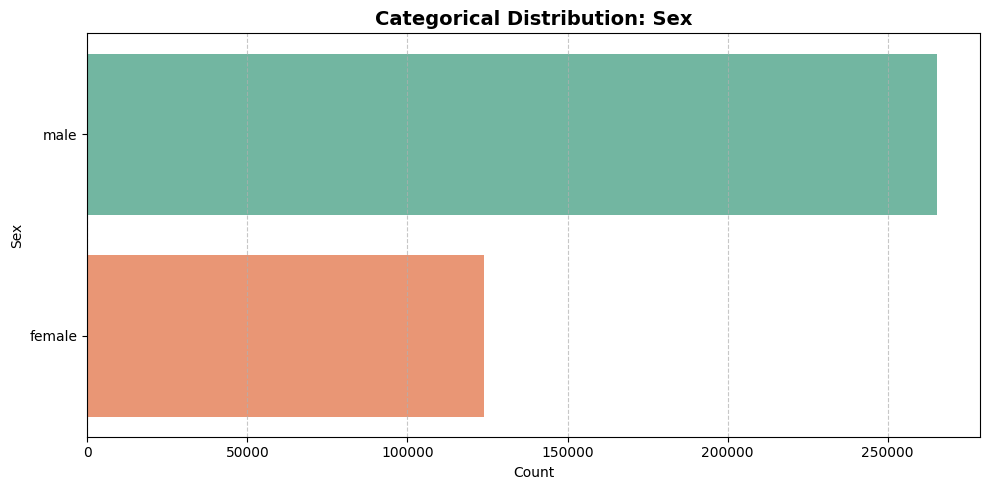

/tmp/ipython-input-12-1815431233.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


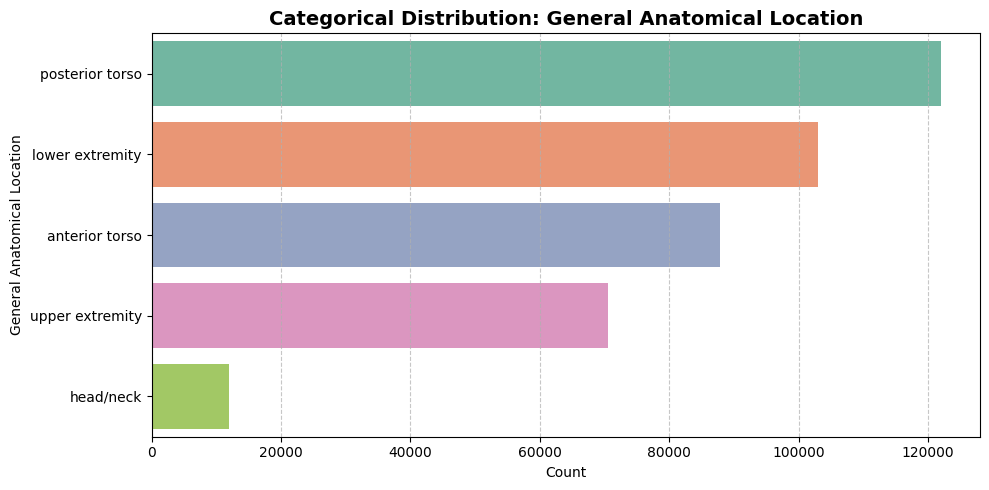

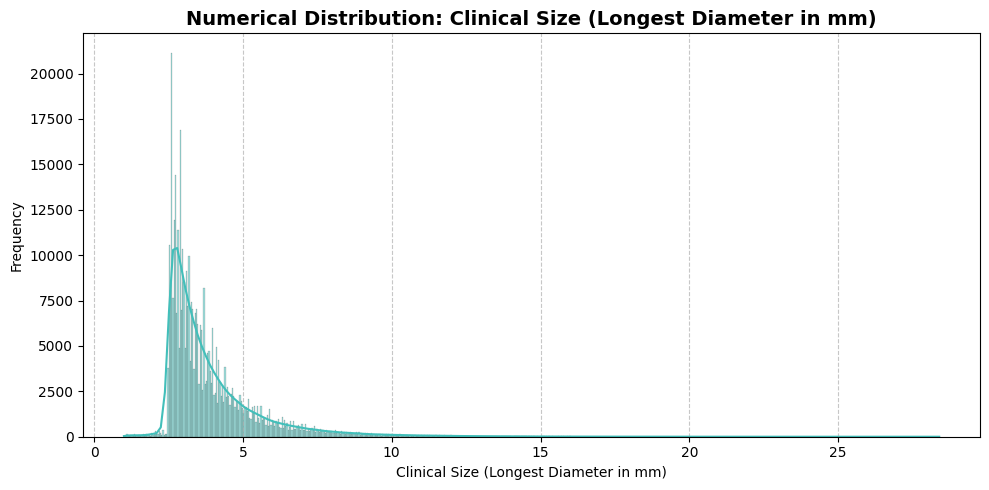

/tmp/ipython-input-12-1815431233.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


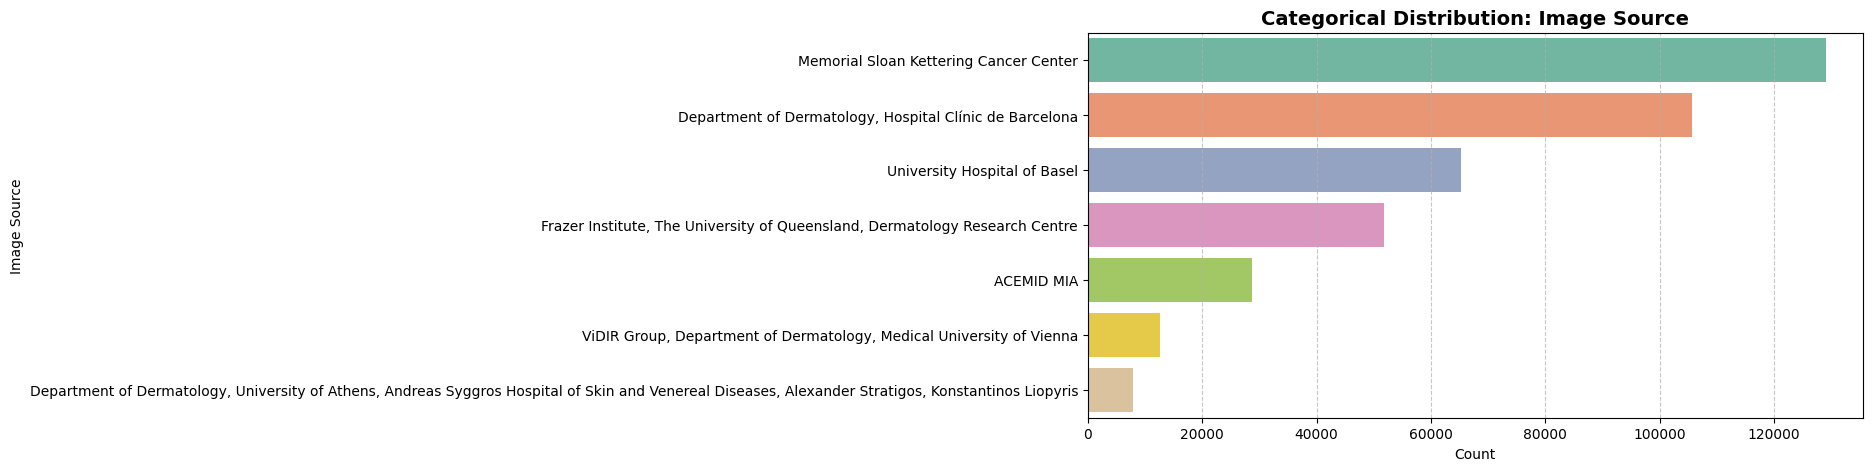

/tmp/ipython-input-12-1815431233.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


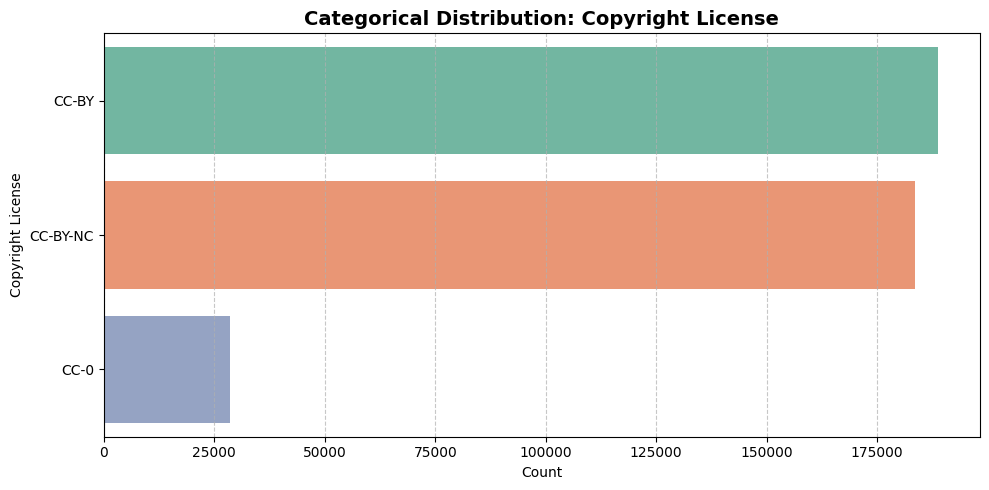

/tmp/ipython-input-12-1815431233.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


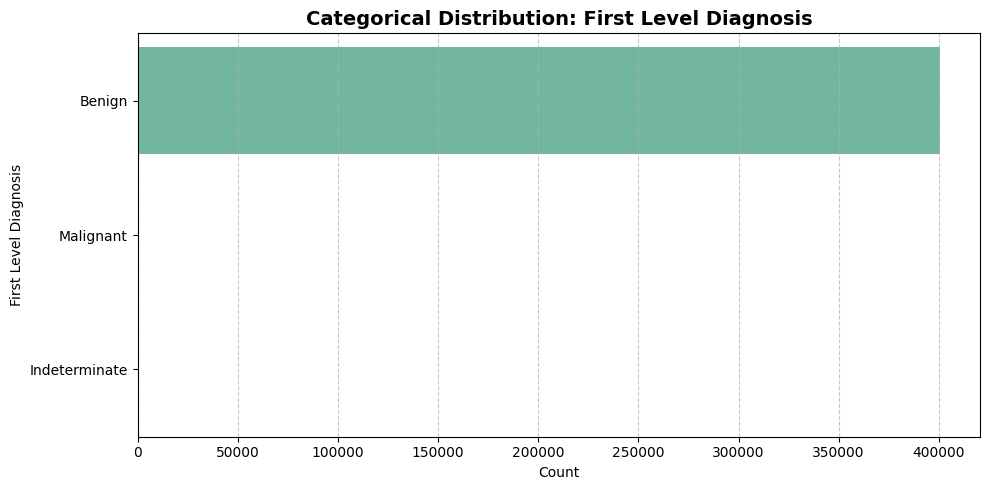

In [12]:
warnings.filterwarnings(
    "ignore",
    message=".*Tight layout not applied.*",
    category=UserWarning
)

category_palette = sns.color_palette("Set2")  # For categorical variables
numeric_color = '#42BFBA'  # For numeric histograms

columns_to_plot = [
    'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm',
    'attribution', 'copyright_license', 'iddx_1'
]

# Replace column names with their friendly names from the dictionary if available
for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    display_name = METADATA_COL2NAME.get(column, column)

    if df[column].dtype == 'object' or df[column].dtype.name == 'category':
        order = df[column].value_counts().index
        sns.countplot(
            y=column,
            data=df,
            order=order,
            palette=sns.color_palette("Set2", len(order))
        )
        plt.title(f"Categorical Distribution: {display_name}", fontsize=14, fontweight='bold')
        plt.xlabel("Count")
        plt.ylabel(display_name)

    else:
        sns.histplot(
            df[column],
            kde=True,
            color=numeric_color,
            edgecolor='black'
        )
        plt.title(f"Numerical Distribution: {display_name}", fontsize=14, fontweight='bold')
        plt.xlabel(display_name)
        plt.ylabel("Frequency")

    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


###DISTRIBUTION OF BENIGN VS MALIGNANT LESIONS

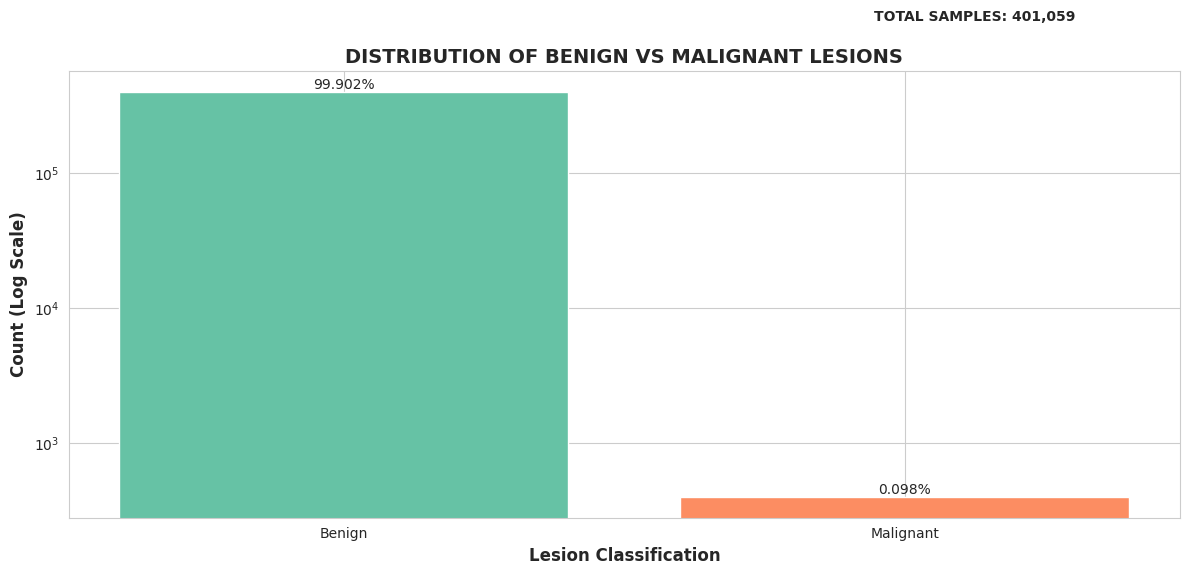

In [23]:
from typing import NoReturn


def plot_target_distribution(df: pd.DataFrame, log_y: bool = True) -> NoReturn:
    """
    Plot the distribution of the target variable as a static bar chart.

    Args:
        df (pd.DataFrame):
            The input dataframe containing the target column.
        log_y (bool, optional):
            Whether to log the y-axis (helpful for visualizing large class imbalance).
            Defaults to True.

    Returns:
        None; This function doesn't return anything, it displays a plot.
    """
    # Set the visual style of the plot
    sns.set_style("whitegrid")

    # Create the figure and axes for the plot.
    # The figsize is adjusted to approximate the original Plotly dimensions (1200x600 pixels).
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- Data Preparation ---
    # Count the occurrences of each target value
    target_counts = df['target'].value_counts().sort_index()

    # Calculate percentages
    total = len(df)
    percentages = [f"{count/total:.3%}" for count in target_counts]

    # --- Plotting ---
    # Create the bar plot
    bars = ax.bar(LABELS, target_counts, color=COLORS)

    # --- Customization ---
    # Set title and labels with bold font
    ax.set_title('DISTRIBUTION OF BENIGN VS MALIGNANT LESIONS', fontweight='bold', fontsize=14)
    ax.set_xlabel('Lesion Classification', fontweight='bold', fontsize=12)

    y_axis_label = 'Count'
    if log_y:
        ax.set_yscale('log')
        y_axis_label += ' (Log Scale)'
    ax.set_ylabel(y_axis_label, fontweight='bold', fontsize=12)

    # Add percentage text on top of each bar
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, percentages[i], va='bottom', ha='center', fontsize=10)

    # Add annotation for total count in the top-right corner
    # The coordinates (0.98, 1.05) are relative to the axes.
    fig.suptitle(f"TOTAL SAMPLES: {total:,}", x=0.9, y=0.95, ha='right', fontweight='bold', fontsize=10)

    # Adjust layout to prevent title/labels from being cut off
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle

    # Show the plot
    plt.show()

# Call the function with the sample DataFrame
plot_target_distribution(df)

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NoReturn, List, Optional

def plot_categorical_feature_distribution(
    df: pd.DataFrame,
    feature_col: str,
    target_col: str = "target",
    target_as_str: bool = True,
    log_y: bool = False,
    color_sequence: Optional[List[str]] = None,
    group_by_target: bool = True,
    stack_bars: bool = False
) -> NoReturn:
    """
    Plot the distribution of a feature as a static chart,
    optionally grouped by the target variable.

    Args:
        df (pd.DataFrame):
            The input dataframe containing feature and target columns.
        feature_col (str):
            Name of the feature column to plot.
        target_col (str, optional):
            Name of the target column. Defaults to "target".
        target_as_str (bool, optional):
            Whether to convert target labels to strings. Defaults to True.
        log_y (bool, optional):
            Whether to use log scale for y-axis. Defaults to False.
        color_sequence (Optional[List[str]], optional):
            Custom color sequence for the bars when not grouping by target.
        group_by_target (bool, optional):
            Whether to group bars by target. Defaults to True.
        stack_bars (bool, optional):
            Whether to stack bars when grouped. Defaults to False.

    Returns:
        None: This function displays a plot and doesn't return anything.
    """
    # Set the visual style of the plot
    sns.set_style("whitegrid")

    # Prevent accidental edits to the original dataframe and handle potential NaNs
    _df = df.copy()
    # **FIX**: Remove rows with NaN values in the feature column instead of labeling them 'Unknown'
    _df.dropna(subset=[feature_col], inplace=True)
    _df = _df.sort_values(by=[feature_col, target_col]).reset_index(drop=True)


    if target_as_str and group_by_target:
        _df[target_col] = _df[target_col].map(LBL_MAP_I2S)

    # Set default color sequence if not provided
    if not color_sequence:
        color_sequence = [plt.cm.viridis(i) for i in range(len(_df[feature_col].unique()))]

    # Create the figure and axes for the plot
    fig, ax = plt.subplots(figsize=(12, 6)) # Increased height for better label visibility

    # --- Plotting ---
    if group_by_target:
        title = f'DISTRIBUTION OF {feature_col.replace("_", " ").upper()} BY TARGET'

        # Aggregate data first to use with barplot for better control
        plot_data = _df.groupby([feature_col, target_col]).size().reset_index(name='count')

        if stack_bars:
            # Use histplot for native stacking
            sns.histplot(
                data=_df, x=feature_col, hue=target_col, multiple="stack",
                palette=COLORS, ax=ax, shrink=0.8, edgecolor='white', linewidth=0.5
            )
        else:
            # Switched to barplot for better visual control and to fix the error.
            sns.barplot(
                data=plot_data, x=feature_col, y='count', hue=target_col,
                palette=COLORS, ax=ax
            )
    else:
        title = f'DISTRIBUTION OF {feature_col.replace("_", " ").upper()}'
        # Use countplot for a simple feature distribution, it's fine here.
        sns.countplot(
            data=_df, x=feature_col, palette=color_sequence, ax=ax
        )
        ax.set_ylabel('Count', fontweight='bold', fontsize=12)


    # --- Customization ---
    # Set title and labels with bold font
    ax.set_title(title, fontweight='bold', fontsize=14, pad=20)
    ax.set_xlabel(feature_col.replace("_", " ").title(), fontweight='bold', fontsize=12)

    y_axis_label = 'Count (log scale)'
    if log_y:
        ax.set_yscale('log')
        # For log scale, barplot might show empty space. We can adjust ylim.
        if not plot_data.empty:
            ax.set_ylim(bottom=0.5) # Start just above 0 for log scale visibility

    # Set Y-axis label (barplot needs it set manually)
    if group_by_target and not stack_bars:
        ax.set_ylabel(y_axis_label, fontweight='bold', fontsize=12)

    # Rotate x-axis labels for better readability if they are long
    plt.xticks(rotation=15, ha='right')

    # Improve legend if it exists
    if group_by_target:
        ax.legend(title=target_col.title())
    elif ax.get_legend() is not None:
        ax.get_legend().remove()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


###Investigation of distribution considering the location and type of lesion

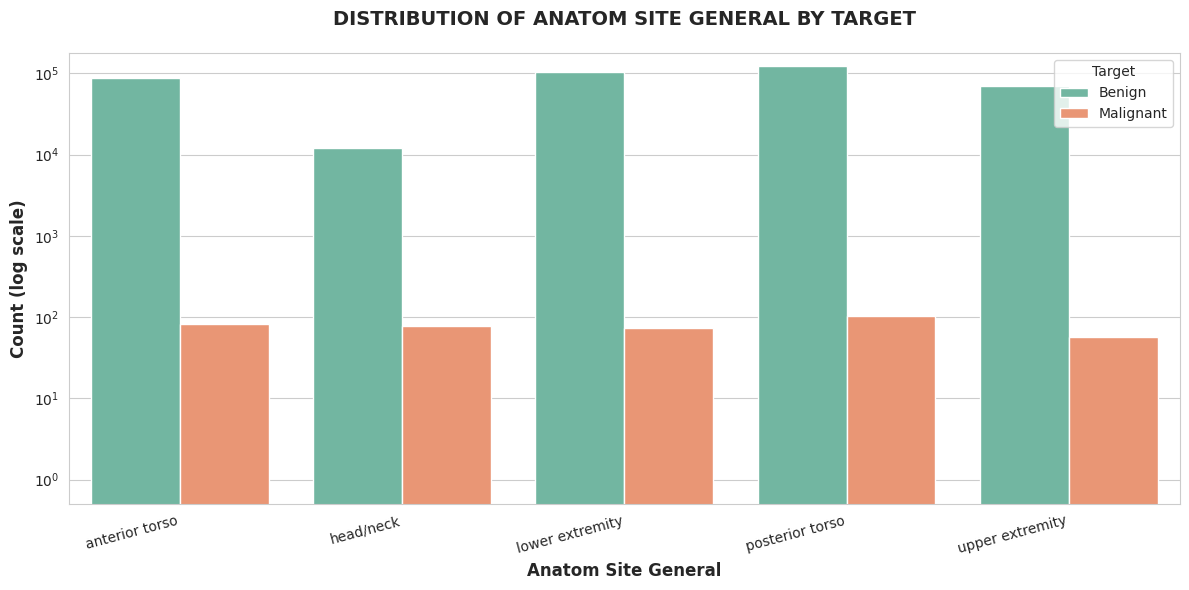

In [37]:
plot_categorical_feature_distribution(df, 'anatom_site_general', group_by_target=True, stack_bars=False, log_y=True)
# plot_categorical_feature_distribution(train_df, 'anatom_site_general', group_by_target=False)

###The type of touch and the combination of the gender columns

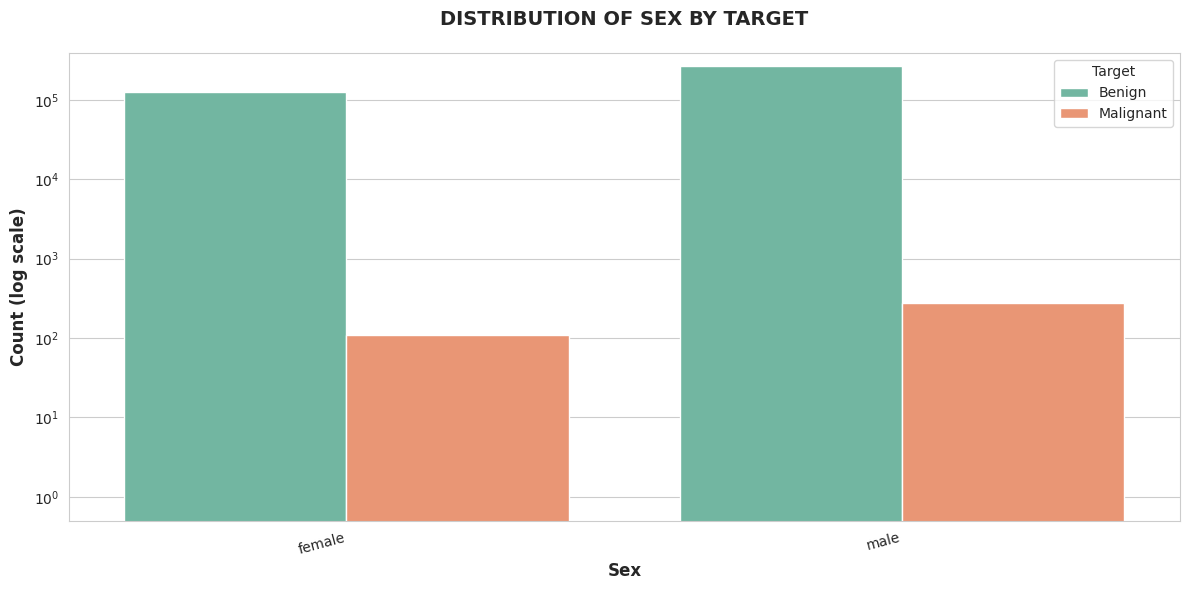

In [38]:
plot_categorical_feature_distribution(df, "sex", group_by_target=True, stack_bars=False, log_y=True)
# plot_categorical_feature_distribution(train_df, "sex", group_by_target=False)

###Type of contact and combination of age columns

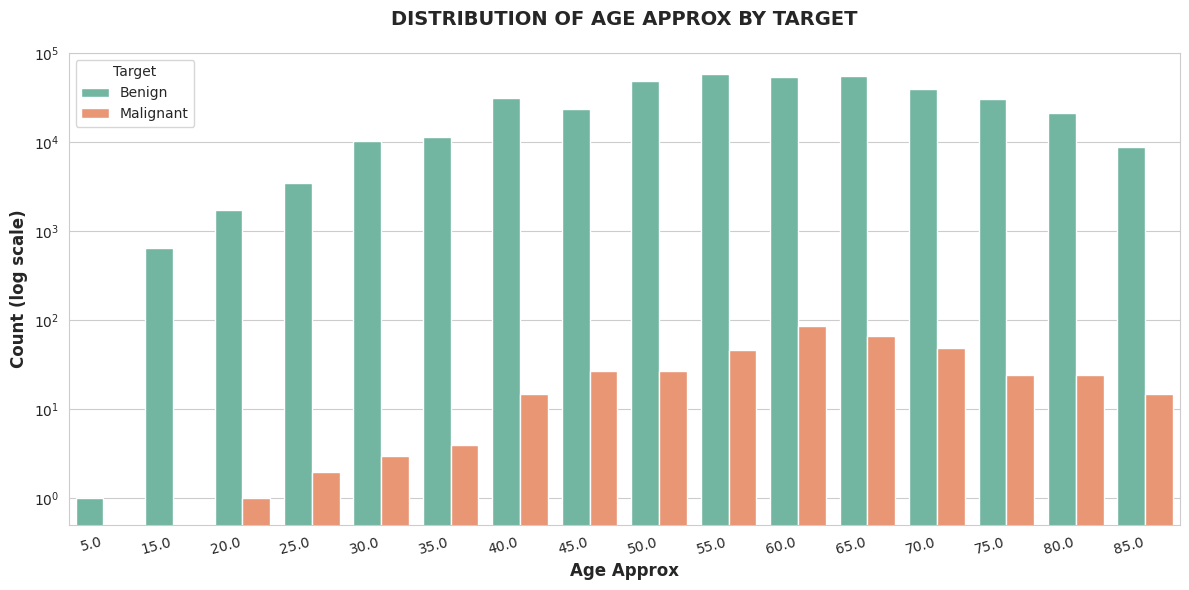

In [39]:
# plot_categorical_feature_distribution(train_df, "age_approx", group_by_target=True, stack_bars=False, log_y=True)
plot_categorical_feature_distribution(df, "age_approx", group_by_target=True, stack_bars=False, log_y=True)

###Type of touch and combination of location columns

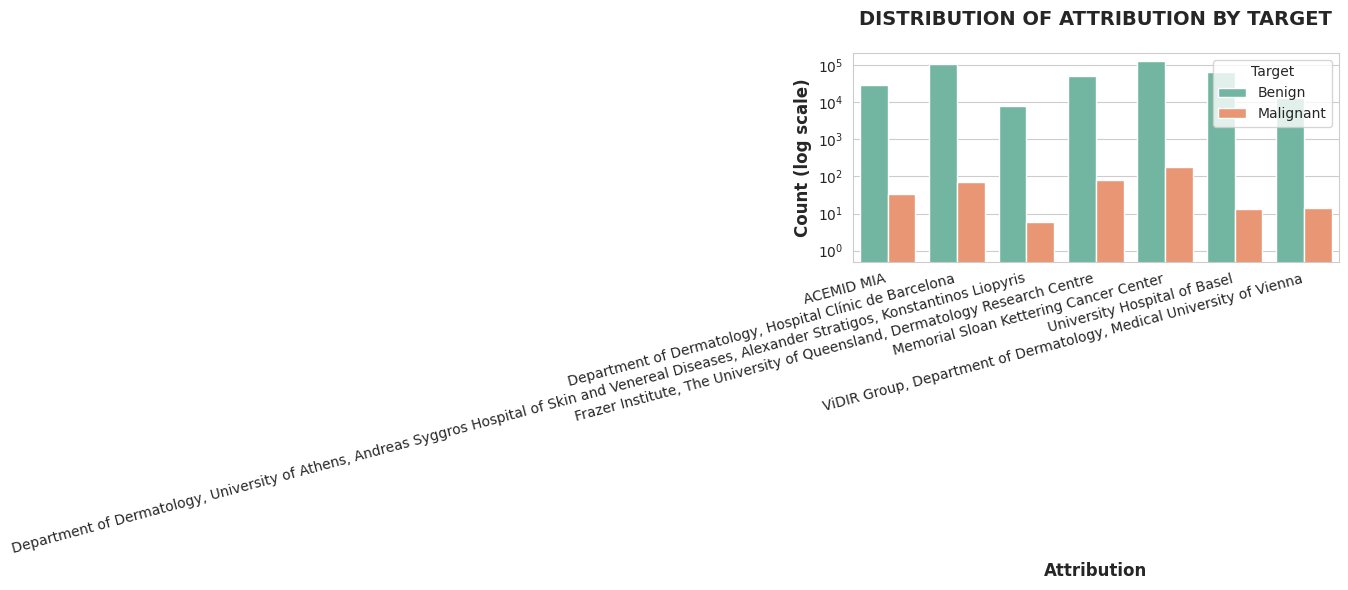

In [40]:
plot_categorical_feature_distribution(df, "attribution", group_by_target=True, stack_bars=False, log_y=True)

In [47]:
def plot_continuous_feature_distribution(
    df: pd.DataFrame,
    feature_col: str,
    plot_style: str = "histogram",
    feature_readable_name: Optional[str] = None,
    target_col: str = "target",
    target_as_str: bool = True,
    log_y: bool = False,
    color_sequence: Optional[List[str]] = None,
    group_by_target: bool = True,
    n_bins: int = 50
) -> NoReturn:
    """
    Plot the distribution of a continuous feature as a static chart,
    optionally grouped by the target variable.

    Args:
        df (pd.DataFrame):
            The input dataframe containing feature and target columns.
        feature_col (str):
            Name of the continuous feature column to plot.
        plot_style (str, optional):
            Type of plot to create. Either "histogram" or "box". Defaults to "histogram".
        feature_readable_name (Optional[str]):
            A readable name for the feature for titles/axes.
        target_col (str, optional):
            Name of the target column. Defaults to "target".
        target_as_str (bool, optional):
            Whether to convert target labels to strings. Defaults to True.
        log_y (bool, optional):
            Whether to use log scale for y-axis (for histograms). Defaults to False.
        color_sequence (Optional[List[str]], optional):
            Custom color sequence. Defaults to COLORS for grouping.
        group_by_target (bool, optional):
            Whether to group the plot by target. Defaults to True.
        n_bins (int, optional):
            Number of bins for the histogram. Defaults to 50.

    Returns:
        None: This function displays a plot and doesn't return anything.
    """
    # Set the visual style
    sns.set_style("whitegrid")

    # Create a copy to avoid modifying the original dataframe
    _df = df.copy().sort_values(by=[feature_col, target_col]).reset_index(drop=True)

    if target_as_str and group_by_target:
        _df[target_col] = _df[target_col].map(LBL_MAP_I2S)

    # Set default color sequence
    if color_sequence is None:
        color_sequence = COLORS if group_by_target else [sns.color_palette()[0]]

    if feature_readable_name is None:
        feature_readable_name = METADATA_COL2NAME.get(feature_col, feature_col.replace("_", " ").title())

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- Plotting Logic ---
    if plot_style == "histogram":
        title = f"DISTRIBUTION OF '{feature_readable_name.upper()}'"
        if group_by_target:
            title += " BY TARGET"
            # **FIX**: Iterate and plot each histogram separately for robust log scaling.
            # This mimics the original Plotly behavior of adding traces.
            unique_targets = _df[target_col].unique()
            for i, target_value in enumerate(unique_targets):
                subset = _df[_df[target_col] == target_value]
                sns.histplot(
                    subset[feature_col],
                    bins=n_bins,
                    color=color_sequence[i % len(color_sequence)],
                    label=str(target_value),
                    alpha=0.7,
                    ax=ax
                )
            # Apply log scale after plotting
            if log_y:
                ax.set_yscale('log')
        else:
            sns.histplot(
                data=_df, x=feature_col, bins=n_bins,
                color=color_sequence[0], ax=ax
            )
            if log_y:
                ax.set_yscale('log')

        ax.set_xlabel(feature_readable_name, fontweight='bold', fontsize=12)
        y_label = 'Count' + (' (Log Scale)' if log_y else '')
        ax.set_ylabel(y_label, fontweight='bold', fontsize=12)

    elif plot_style == "box":
        title = f"DISTRIBUTION OF '{feature_readable_name.upper()}'"
        if group_by_target:
            title += " BY TARGET"
            sns.boxplot(
                data=_df, x=target_col, y=feature_col,
                palette=color_sequence, ax=ax, showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"8"}
            )
            ax.set_xlabel('Target', fontweight='bold', fontsize=12)
        else:
            sns.boxplot(data=_df, y=feature_col, color=color_sequence[0], ax=ax, showmeans=True)
            ax.set_xlabel('')

        ax.set_ylabel(feature_readable_name, fontweight='bold', fontsize=12)

    else:
        raise ValueError("Invalid plot_style. Choose either 'histogram' or 'box'.")

    # --- Customization ---
    ax.set_title(title, fontweight='bold', fontsize=14, pad=20)

    # Add legend if it was created
    if group_by_target and plot_style == "histogram":
        ax.legend(title=target_col.title())
    elif group_by_target and ax.get_legend() is not None:
         ax.legend(title=target_col.title())


    plt.tight_layout()
    plt.show()

#Variation in lesion size and type

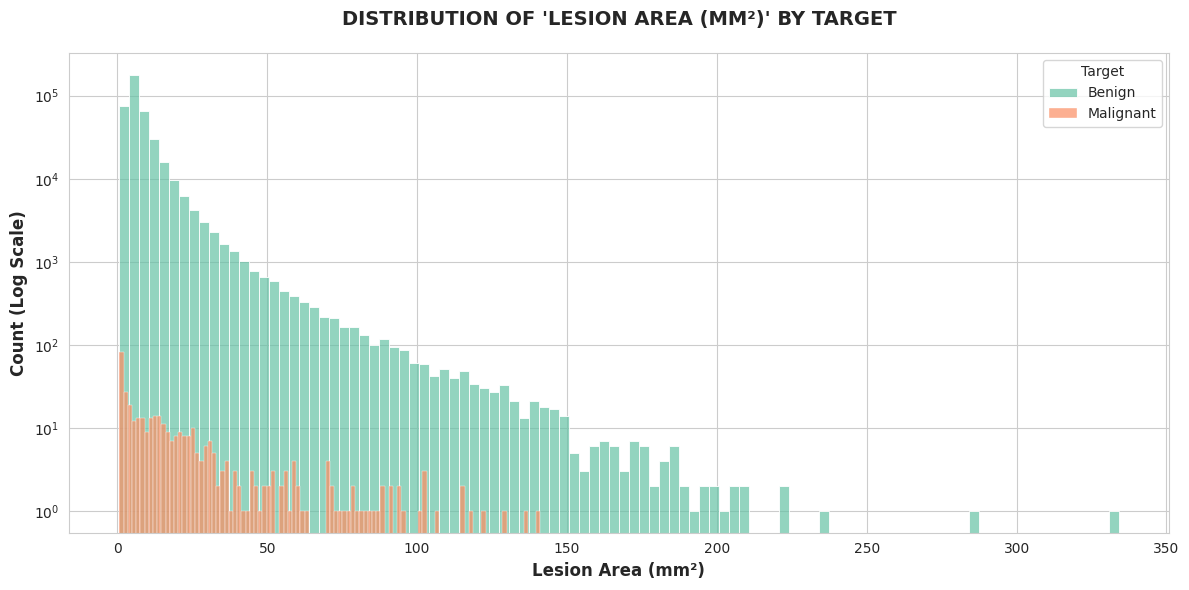

In [48]:
# Lesion Area
plot_continuous_feature_distribution(df, 'tbp_lv_areaMM2', plot_style="histogram", log_y=True, group_by_target=True, n_bins=100)

###visualizing the distribution of the lesion's perimeter (tbp_lv_perimeterMM) using a box plot, split by target class (Benign vs. Malignant), with a logarithmic y-axis to highlight group differences and potential outlier

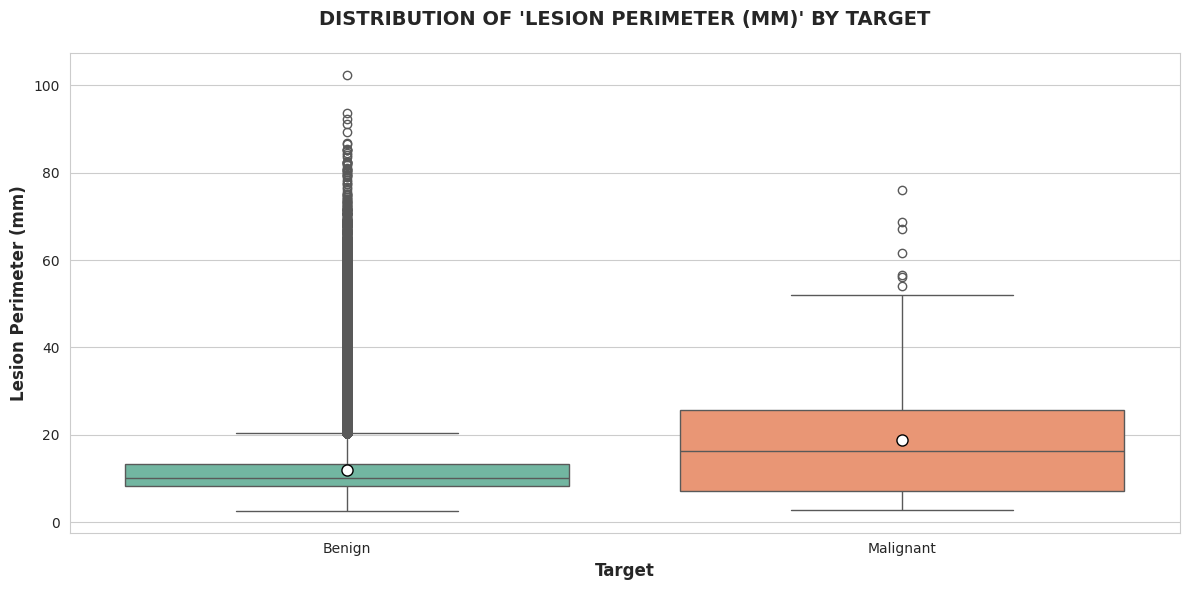

In [49]:
# Lesion Perimeter
plot_continuous_feature_distribution(df, 'tbp_lv_perimeterMM', plot_style="box", log_y=True, group_by_target=True, n_bins=100)

###visualizing the distribution of the clinical lesion size (clin_size_long_diam_mm) using a box plot, grouped by the target class (Benign vs. Malignant), with a logarithmic y-axis to better reveal variations and outliers between the two classes.


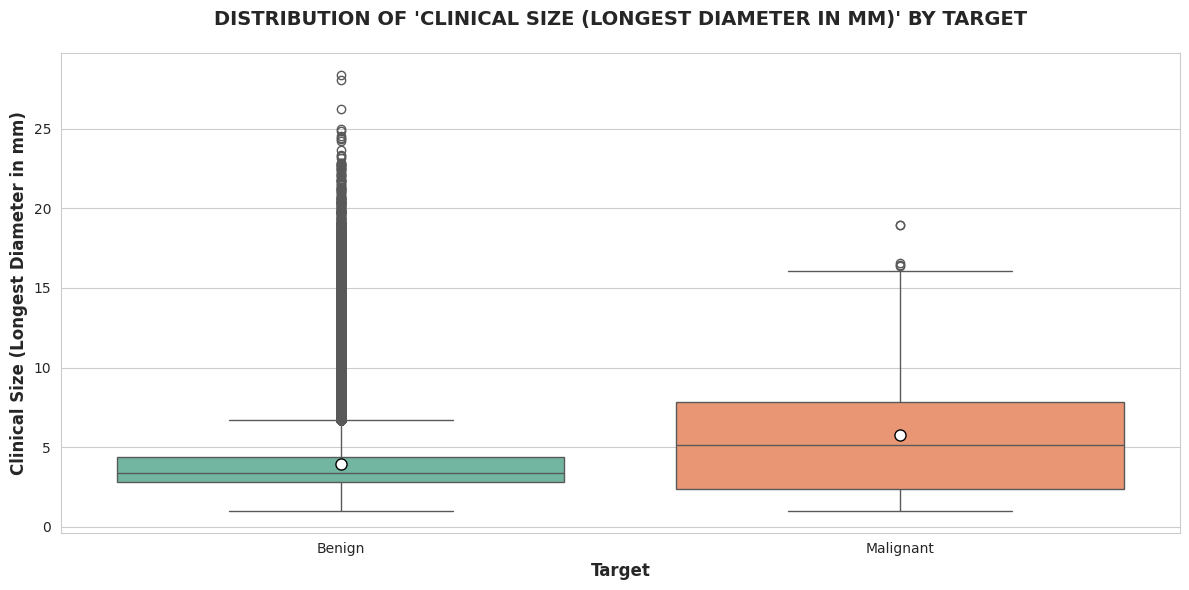

In [50]:
# Lesion Diameter
plot_continuous_feature_distribution(df, 'clin_size_long_diam_mm', plot_style="box", log_y=True, group_by_target=True)